# Hologram-Core Performance Analysis

This notebook analyzes benchmark results from the hologram-core comprehensive benchmark suite.

## Setup

First, ensure you have run the benchmarks:
```bash
cd /workspace
cargo bench --bench comprehensive_suite
```

This will generate `benchmarks/benchmark_results_{timestamp}.json` and automatically create a symlink at `benchmarks/benchmark_results_current.json` pointing to the latest results.

The notebook will automatically load from `benchmarks/benchmark_results_current.json` for convenience.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import glob
from pathlib import Path

# Set style for beautiful plots
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Benchmark Data

In [34]:
# Load the latest benchmark results via symlink
workspace_path = Path('/workspace')
benchmarks_dir = workspace_path / 'benchmarks'
current_file = benchmarks_dir / 'benchmark_results_current.json'

# Fallback to searching if symlink doesn't exist
if not current_file.exists():
    print("Note: benchmark_results_current.json not found, searching for latest file...")
    benchmark_files = sorted(benchmarks_dir.glob('benchmark_results_*.json'), reverse=True)
    if not benchmark_files:
        raise FileNotFoundError("No benchmark results found. Please run: cargo bench --bench comprehensive_suite")
    current_file = benchmark_files[0]

print(f"Loading benchmark results from: {current_file.name}")

# Load JSON data
with open(current_file, 'r') as f:
    data = json.load(f)

# Extract metadata
metadata = data['metadata']
print(f"\nBenchmark Metadata:")
print(f"  Timestamp: {metadata['timestamp']}")
print(f"  Platform: {metadata['platform']}")
print(f"  Backend: {metadata['backend']}")
print(f"  Rust Version: {metadata['rust_version']}")

# Convert to DataFrame
df = pd.DataFrame(data['benchmarks'])

print(f"\nLoaded {len(df)} benchmark results")
print(f"\nDataFrame shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

# Display first few rows
df.head()

Loading benchmark results from: benchmark_results_current.json

Benchmark Metadata:
  Timestamp: 2025-11-03T17:11:51
  Platform: linux
  Backend: cpu
  Rust Version: 1.93.0-nightly

Loaded 118 benchmark results

DataFrame shape: (118, 11)

Columns: ['operation', 'category', 'size', 'addressing_mode', 'mean_time_ns', 'std_dev_ns', 'min_time_ns', 'max_time_ns', 'throughput_mops', 'elements_per_us', 'iterations']


,operation,category,size,addressing_mode,mean_time_ns,std_dev_ns,min_time_ns,max_time_ns,throughput_mops,elements_per_us,iterations
0,vector_add,math,256,BufferOffset,115.41,17.548273,83.0,125.0,2218.178667,2218.178667,100
1,vector_sub,math,256,BufferOffset,116.25,17.981866,83.0,167.0,2202.150538,2202.150538,100
2,vector_mul,math,256,BufferOffset,117.49,16.030281,83.0,125.0,2178.908843,2178.908843,100
3,vector_div,math,256,BufferOffset,118.76,14.855383,83.0,125.0,2155.607949,2155.607949,100
4,min,math,256,BufferOffset,202446.11,158067.794960,172706.0,1494023.0,1.264534,1.264534,100


## Data Preprocessing and Summary Statistics

In [35]:
# Add derived metrics
df['mean_time_us'] = df['mean_time_ns'] / 1000
df['mean_time_ms'] = df['mean_time_ns'] / 1_000_000
df['cv'] = df['std_dev_ns'] / df['mean_time_ns']  # Coefficient of variation

# Summary statistics by category
print("\n=== Summary Statistics by Category ===")
print(df.groupby('category')['mean_time_us'].describe())

# Count of benchmarks by category
print("\n=== Benchmark Count by Category ===")
print(df['category'].value_counts())

# Addressing mode distribution
print("\n=== Addressing Mode Distribution ===")
print(df['addressing_mode'].value_counts())


=== Summary Statistics by Category ===
            count          mean            std       min         25%  \
category                                                               
activation   16.0     12.575571      13.516688   0.77835    2.314907   
linalg       12.0   2136.938812    3915.858687   0.48428   52.232745   
loss         12.0  70064.362957  174086.347239  87.83204  361.440198   
math         55.0  27265.710712   86113.739851   0.08949    0.448730   
memory        8.0  21360.624802   38381.122231  39.47636  200.754813   
reduction    15.0   7666.471069   10942.666714  42.64747  283.720685   

                    50%           75%           max  
category                                             
activation     8.011255     19.487070      38.28625  
linalg       426.046990   1349.764780   11117.25022  
loss        2380.589620  25575.602973  601212.32560  
math           4.797810   1827.541940  536940.10279  
memory      1712.274045  18967.858945   99960.92182  
reduc

## Visualization 1: Performance Overview by Category

/tmp/ipykernel_3074165/1770502017.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='category', y='mean_time_us', ax=axes[1, 0], palette='Set2')


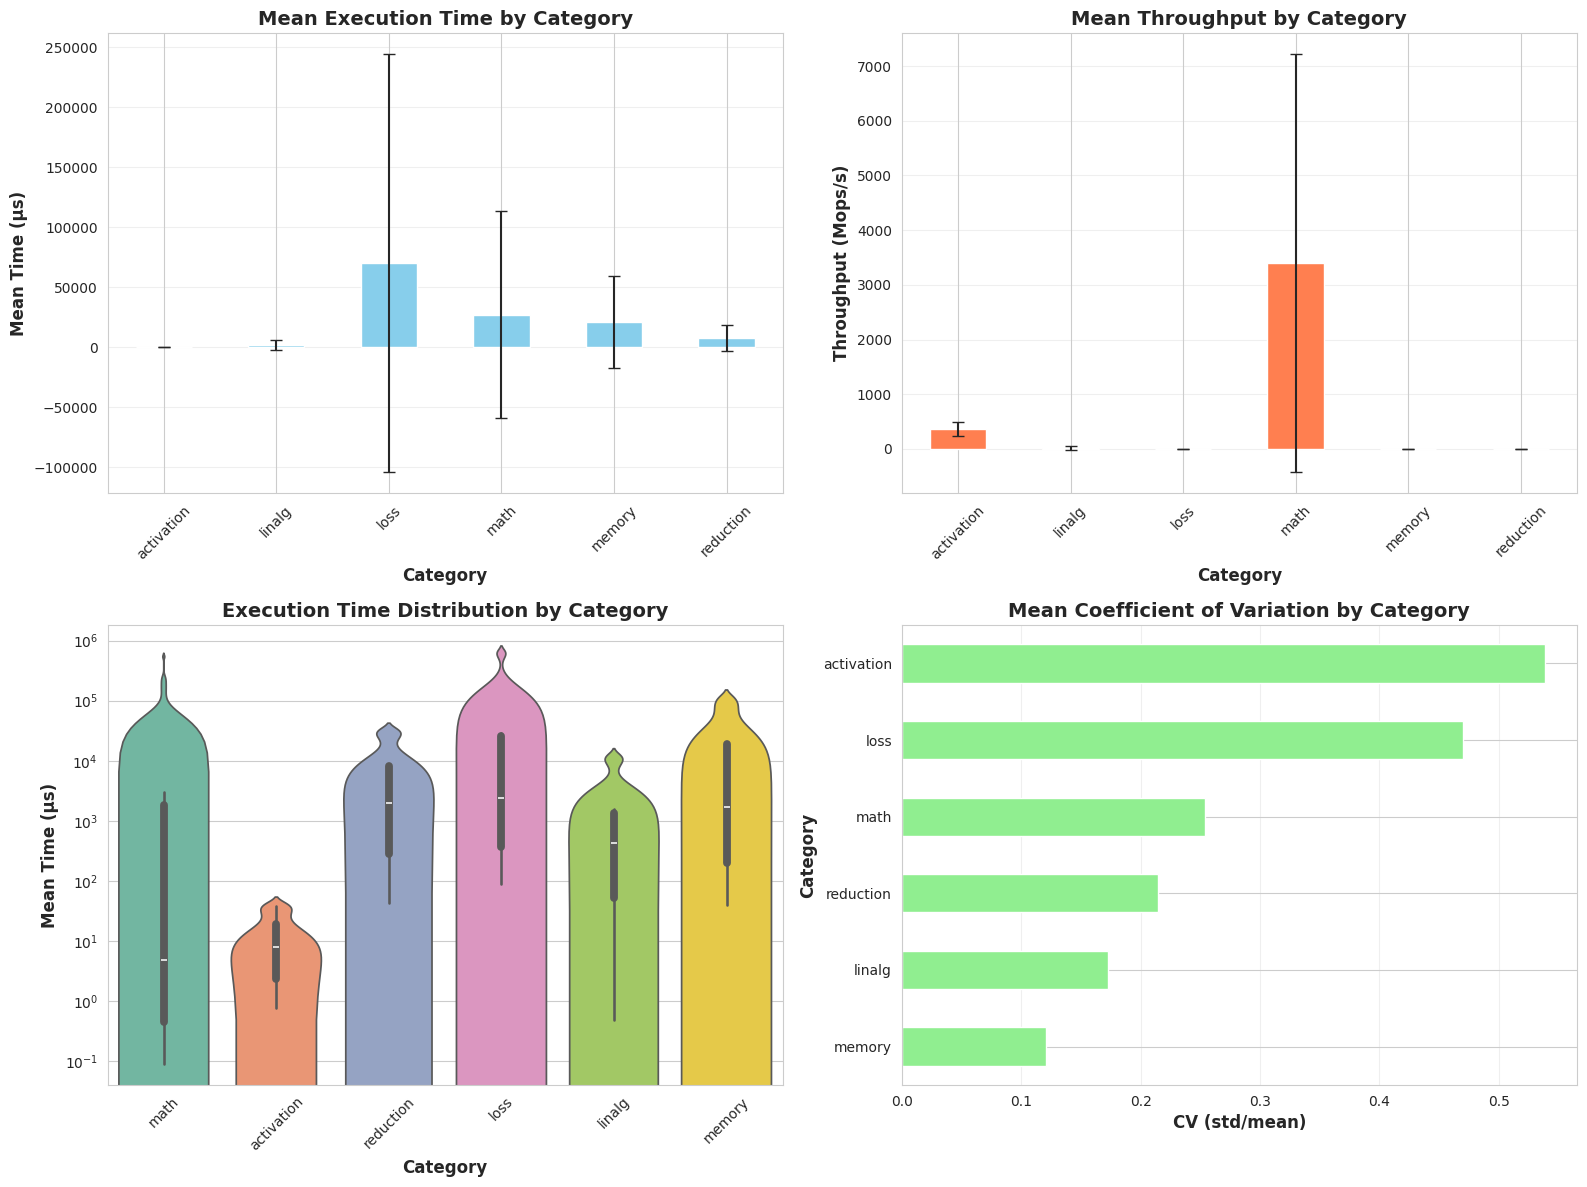

Category overview visualization complete!


In [36]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Mean execution time by category
category_summary = df.groupby('category')['mean_time_us'].agg(['mean', 'std', 'min', 'max'])
category_summary.plot(kind='bar', y='mean', yerr='std', ax=axes[0, 0], 
                      color='skyblue', capsize=4, legend=False)
axes[0, 0].set_title('Mean Execution Time by Category', fontweight='bold', fontsize=14)
axes[0, 0].set_xlabel('Category', fontweight='bold')
axes[0, 0].set_ylabel('Mean Time (µs)', fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Throughput by category
throughput_summary = df.groupby('category')['throughput_mops'].agg(['mean', 'std'])
throughput_summary.plot(kind='bar', y='mean', yerr='std', ax=axes[0, 1],
                        color='coral', capsize=4, legend=False)
axes[0, 1].set_title('Mean Throughput by Category', fontweight='bold', fontsize=14)
axes[0, 1].set_xlabel('Category', fontweight='bold')
axes[0, 1].set_ylabel('Throughput (Mops/s)', fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Distribution of execution times (violin plot)
sns.violinplot(data=df, x='category', y='mean_time_us', ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('Execution Time Distribution by Category', fontweight='bold', fontsize=14)
axes[1, 0].set_xlabel('Category', fontweight='bold')
axes[1, 0].set_ylabel('Mean Time (µs)', fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_yscale('log')

# 4. Coefficient of variation by category
cv_summary = df.groupby('category')['cv'].mean().sort_values()
cv_summary.plot(kind='barh', ax=axes[1, 1], color='lightgreen')
axes[1, 1].set_title('Mean Coefficient of Variation by Category', fontweight='bold', fontsize=14)
axes[1, 1].set_xlabel('CV (std/mean)', fontweight='bold')
axes[1, 1].set_ylabel('Category', fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('category_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("Category overview visualization complete!")

## Visualization 2: Scaling Analysis

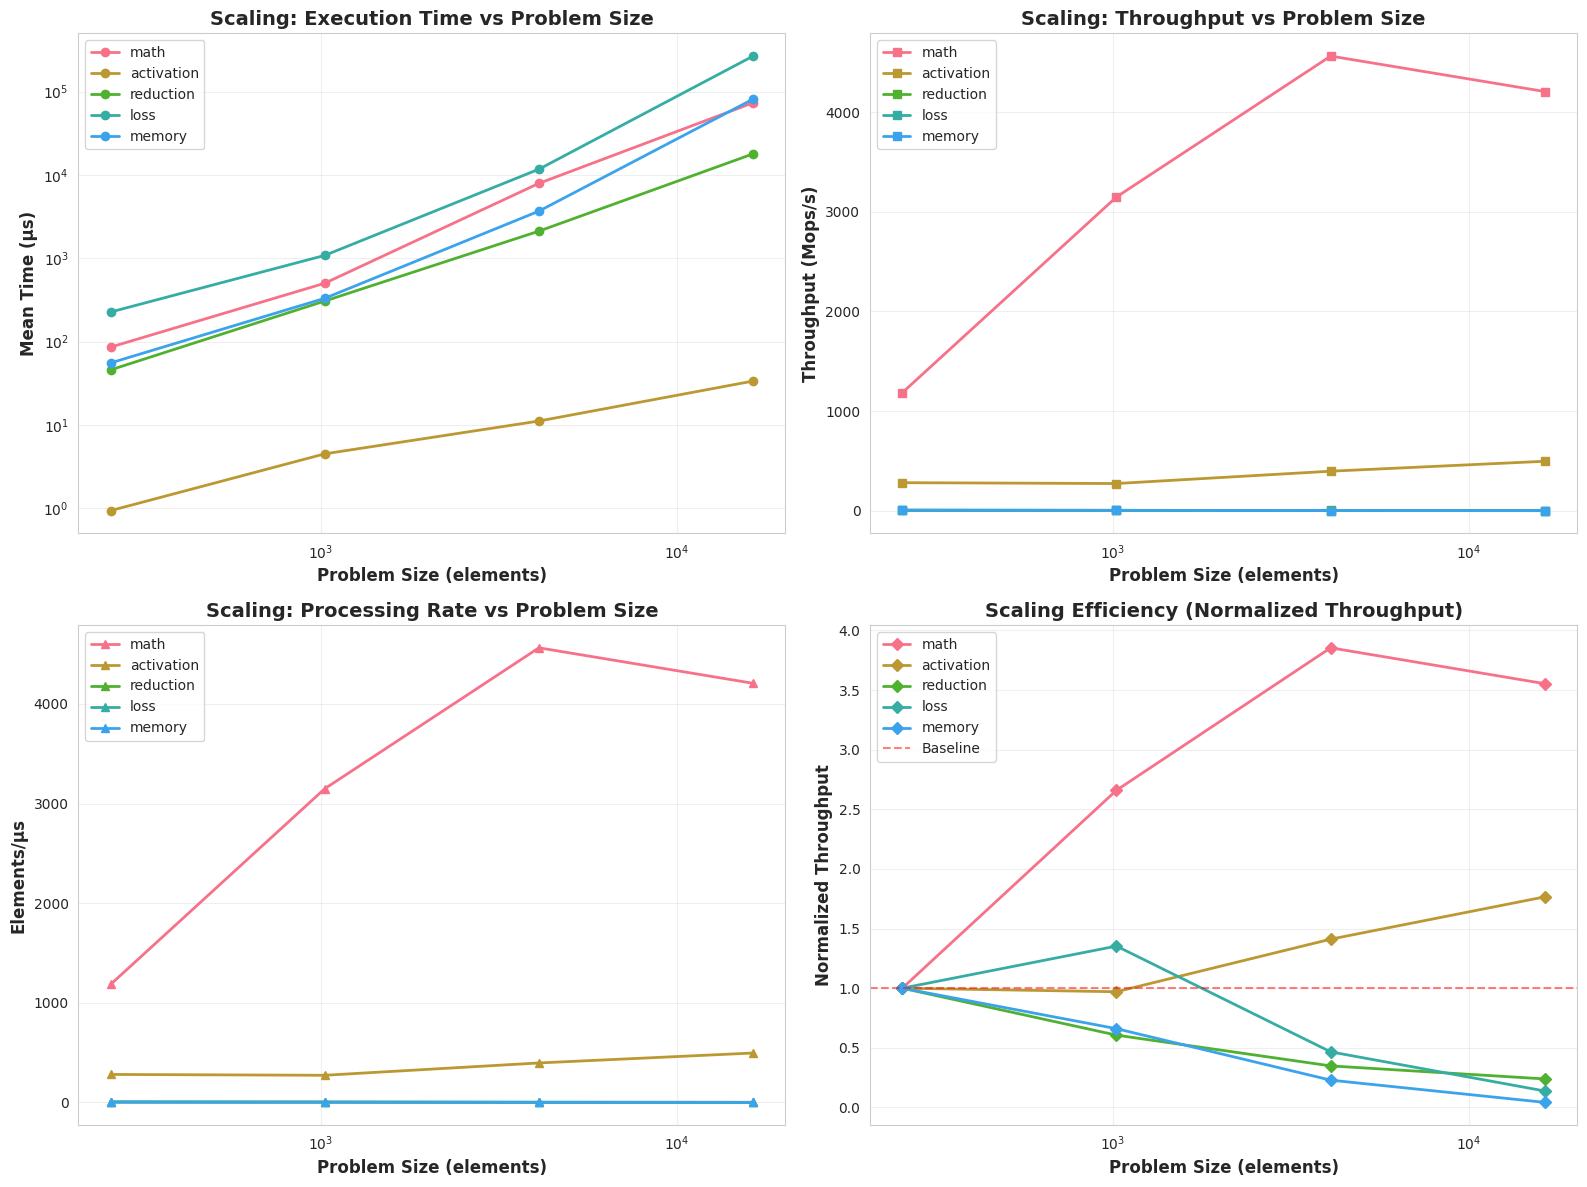

Scaling analysis visualization complete!


In [37]:
# Filter for operations with multiple sizes (exclude GEMM/MatVec which have different size semantics)
standard_ops_df = df[~df['operation'].str.contains('gemm|matvec', case=False)].copy()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Execution time vs size (by category)
for category in standard_ops_df['category'].unique():
    cat_data = standard_ops_df[standard_ops_df['category'] == category]
    size_avg = cat_data.groupby('size')['mean_time_us'].mean()
    axes[0, 0].plot(size_avg.index, size_avg.values, marker='o', label=category, linewidth=2)

axes[0, 0].set_title('Scaling: Execution Time vs Problem Size', fontweight='bold', fontsize=14)
axes[0, 0].set_xlabel('Problem Size (elements)', fontweight='bold')
axes[0, 0].set_ylabel('Mean Time (µs)', fontweight='bold')
axes[0, 0].set_xscale('log')
axes[0, 0].set_yscale('log')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Throughput vs size (by category)
for category in standard_ops_df['category'].unique():
    cat_data = standard_ops_df[standard_ops_df['category'] == category]
    size_avg = cat_data.groupby('size')['throughput_mops'].mean()
    axes[0, 1].plot(size_avg.index, size_avg.values, marker='s', label=category, linewidth=2)

axes[0, 1].set_title('Scaling: Throughput vs Problem Size', fontweight='bold', fontsize=14)
axes[0, 1].set_xlabel('Problem Size (elements)', fontweight='bold')
axes[0, 1].set_ylabel('Throughput (Mops/s)', fontweight='bold')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Elements per microsecond vs size
for category in standard_ops_df['category'].unique():
    cat_data = standard_ops_df[standard_ops_df['category'] == category]
    size_avg = cat_data.groupby('size')['elements_per_us'].mean()
    axes[1, 0].plot(size_avg.index, size_avg.values, marker='^', label=category, linewidth=2)

axes[1, 0].set_title('Scaling: Processing Rate vs Problem Size', fontweight='bold', fontsize=14)
axes[1, 0].set_xlabel('Problem Size (elements)', fontweight='bold')
axes[1, 0].set_ylabel('Elements/µs', fontweight='bold')
axes[1, 0].set_xscale('log')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Scaling efficiency (normalized throughput)
for category in standard_ops_df['category'].unique():
    cat_data = standard_ops_df[standard_ops_df['category'] == category]
    size_avg = cat_data.groupby('size')['throughput_mops'].mean()
    if len(size_avg) > 0:
        normalized = size_avg / size_avg.iloc[0]  # Normalize to smallest size
        axes[1, 1].plot(size_avg.index, normalized.values, marker='D', label=category, linewidth=2)

axes[1, 1].set_title('Scaling Efficiency (Normalized Throughput)', fontweight='bold', fontsize=14)
axes[1, 1].set_xlabel('Problem Size (elements)', fontweight='bold')
axes[1, 1].set_ylabel('Normalized Throughput', fontweight='bold')
axes[1, 1].set_xscale('log')
axes[1, 1].axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Baseline')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('scaling_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Scaling analysis visualization complete!")

## Visualization 3: Addressing Mode Comparison

In [38]:
# Filter for operations that have both addressing modes
both_modes = df.groupby(['operation', 'size', 'category']).filter(lambda x: len(x['addressing_mode'].unique()) == 2)

if len(both_modes) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Side-by-side comparison
    comparison_data = both_modes.pivot_table(
        index=['operation', 'size'], 
        columns='addressing_mode', 
        values='mean_time_us'
    ).reset_index()
    
    if 'PhiCoordinate' in comparison_data.columns and 'BufferOffset' in comparison_data.columns:
        comparison_data['speedup'] = comparison_data['BufferOffset'] / comparison_data['PhiCoordinate']
        
        # Bar chart of speedup
        speedup_by_op = comparison_data.groupby('operation')['speedup'].mean().sort_values(ascending=False)
        speedup_by_op.plot(kind='barh', ax=axes[0], color='steelblue')
        axes[0].set_title('PhiCoordinate Speedup vs BufferOffset', fontweight='bold', fontsize=14)
        axes[0].set_xlabel('Speedup Factor', fontweight='bold')
        axes[0].set_ylabel('Operation', fontweight='bold')
        axes[0].axvline(x=1.0, color='red', linestyle='--', alpha=0.5, label='Equal Performance')
        axes[0].legend()
        axes[0].grid(axis='x', alpha=0.3)
        
        # Grouped bar chart comparing both modes
        mode_comparison = both_modes.groupby(['category', 'addressing_mode'])['mean_time_us'].mean().unstack()
        mode_comparison.plot(kind='bar', ax=axes[1], width=0.8)
        axes[1].set_title('Mean Execution Time by Addressing Mode', fontweight='bold', fontsize=14)
        axes[1].set_xlabel('Category', fontweight='bold')
        axes[1].set_ylabel('Mean Time (µs)', fontweight='bold')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].legend(title='Addressing Mode')
        axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('addressing_mode_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print speedup statistics
    if 'speedup' in comparison_data.columns:
        print(f"\n=== PhiCoordinate Speedup Statistics ===")
        print(f"Mean speedup: {comparison_data['speedup'].mean():.2f}x")
        print(f"Median speedup: {comparison_data['speedup'].median():.2f}x")
        print(f"Max speedup: {comparison_data['speedup'].max():.2f}x")
        print(f"Min speedup: {comparison_data['speedup'].min():.2f}x")
else:
    print("No operations found with both addressing modes for comparison.")

No operations found with both addressing modes for comparison.


## Visualization 4: Operation-Specific Performance Heatmaps

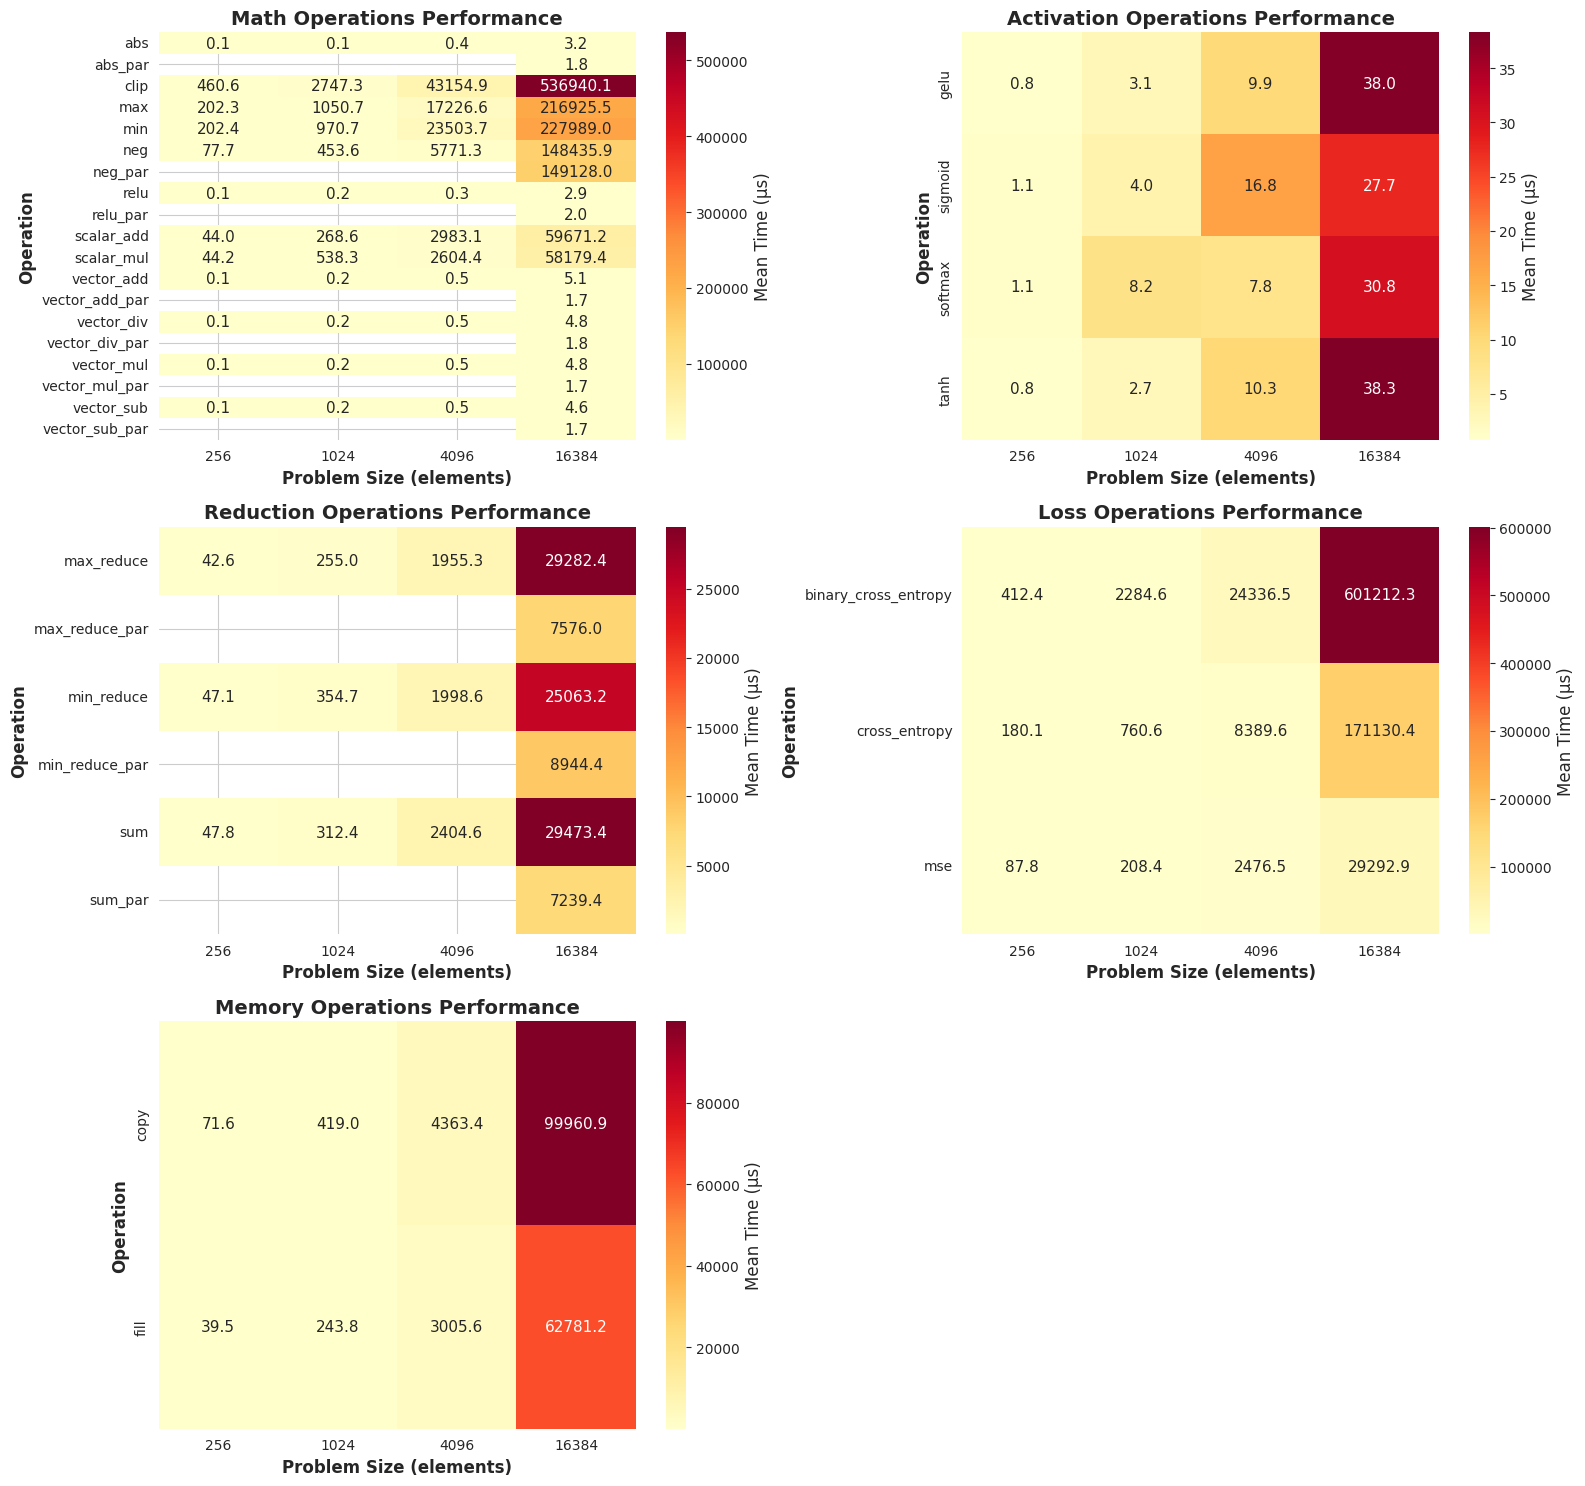

Performance heatmaps visualization complete!


In [39]:
# Create heatmaps for each category
categories = standard_ops_df['category'].unique()
n_categories = len(categories)
n_cols = 2
n_rows = (n_categories + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten() if n_categories > 1 else [axes]

for idx, category in enumerate(categories):
    cat_data = standard_ops_df[standard_ops_df['category'] == category]
    
    # Create pivot table for heatmap
    heatmap_data = cat_data.pivot_table(
        index='operation',
        columns='size',
        values='mean_time_us',
        aggfunc='mean'
    )
    
    if not heatmap_data.empty:
        sns.heatmap(
            heatmap_data,
            annot=True,
            fmt='.1f',
            cmap='YlOrRd',
            ax=axes[idx],
            cbar_kws={'label': 'Mean Time (µs)'}
        )
        axes[idx].set_title(f'{category.capitalize()} Operations Performance', fontweight='bold', fontsize=14)
        axes[idx].set_xlabel('Problem Size (elements)', fontweight='bold')
        axes[idx].set_ylabel('Operation', fontweight='bold')

# Hide unused subplots
for idx in range(n_categories, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('performance_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

print("Performance heatmaps visualization complete!")

## Visualization 5: Top Performers and Detailed Math Operations

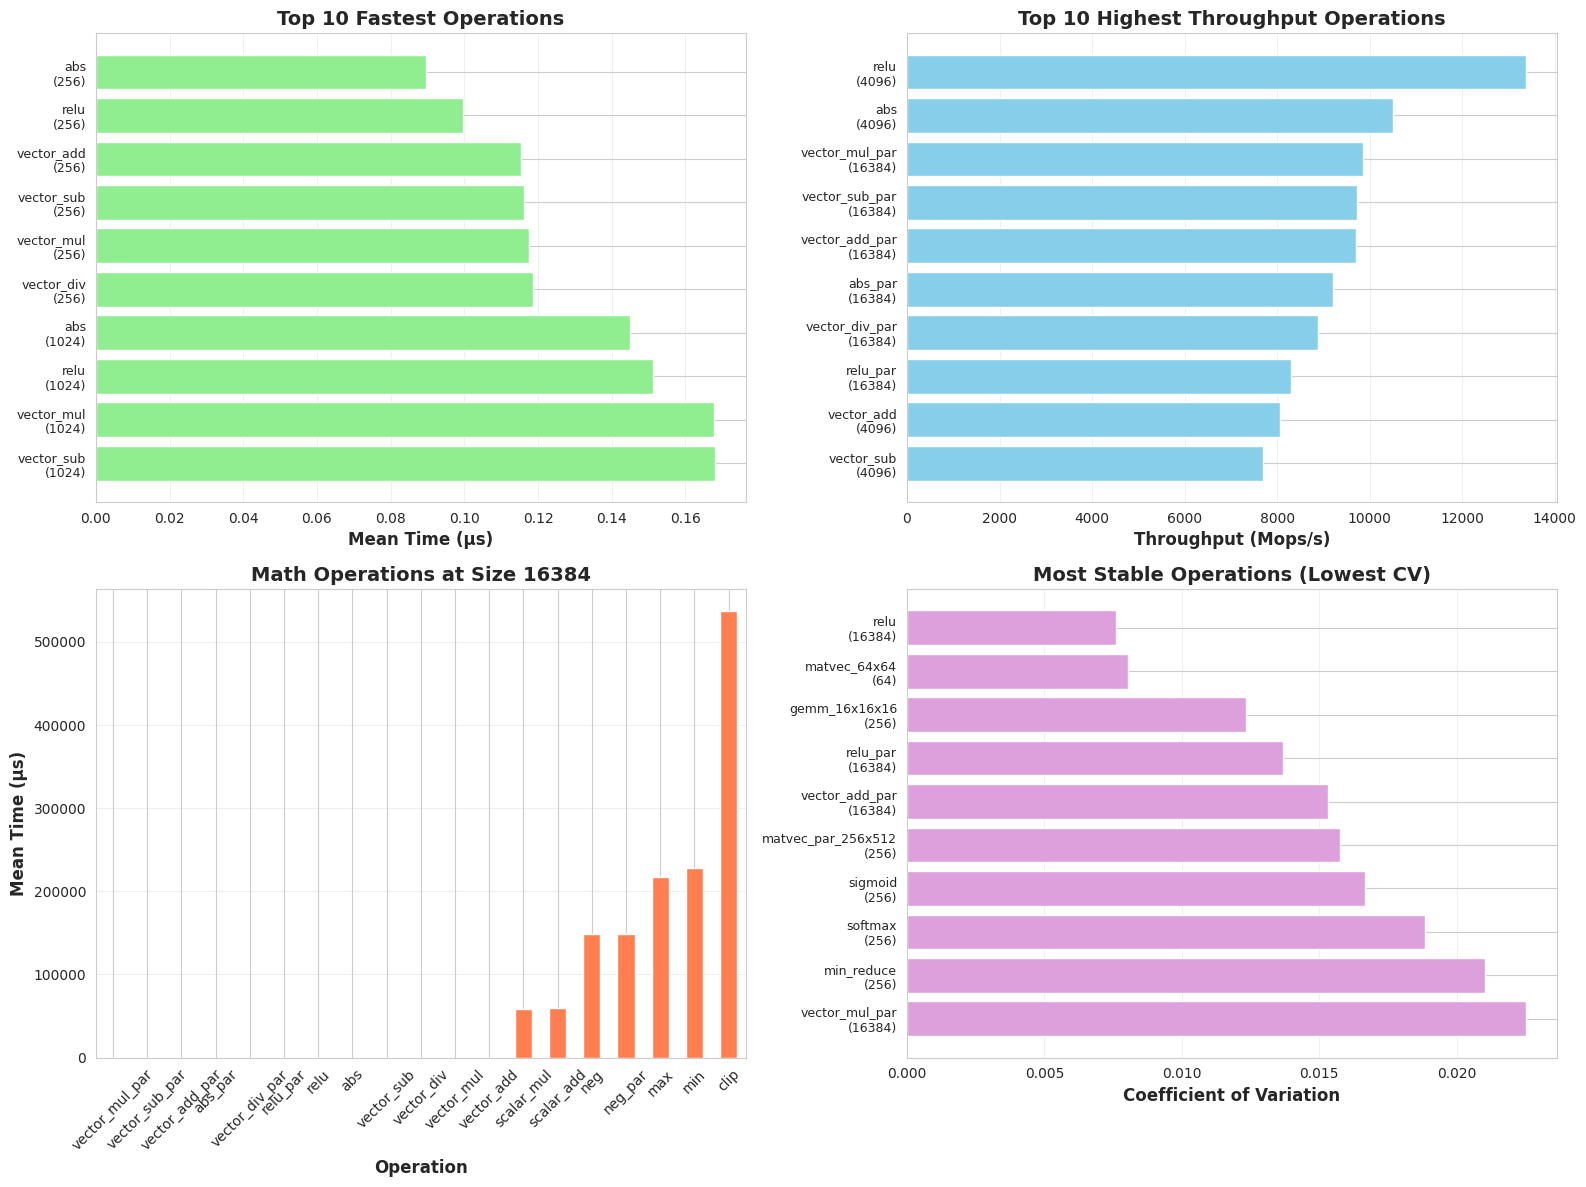

Top performers visualization complete!


In [40]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 10 fastest operations (by mean time)
fastest = df.nsmallest(10, 'mean_time_us')[['operation', 'size', 'mean_time_us', 'category']]
fastest_labels = fastest['operation'] + '\n(' + fastest['size'].astype(str) + ')'
axes[0, 0].barh(range(len(fastest)), fastest['mean_time_us'], color='lightgreen')
axes[0, 0].set_yticks(range(len(fastest)))
axes[0, 0].set_yticklabels(fastest_labels, fontsize=9)
axes[0, 0].set_title('Top 10 Fastest Operations', fontweight='bold', fontsize=14)
axes[0, 0].set_xlabel('Mean Time (µs)', fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Top 10 highest throughput operations
highest_throughput = df.nlargest(10, 'throughput_mops')[['operation', 'size', 'throughput_mops', 'category']]
throughput_labels = highest_throughput['operation'] + '\n(' + highest_throughput['size'].astype(str) + ')'
axes[0, 1].barh(range(len(highest_throughput)), highest_throughput['throughput_mops'], color='skyblue')
axes[0, 1].set_yticks(range(len(highest_throughput)))
axes[0, 1].set_yticklabels(throughput_labels, fontsize=9)
axes[0, 1].set_title('Top 10 Highest Throughput Operations', fontweight='bold', fontsize=14)
axes[0, 1].set_xlabel('Throughput (Mops/s)', fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Math operations detailed comparison (largest size only)
math_ops = df[df['category'] == 'math']
if len(math_ops) > 0:
    max_size = math_ops['size'].max()
    math_largest = math_ops[math_ops['size'] == max_size].sort_values('mean_time_us')
    
    math_largest.plot(x='operation', y='mean_time_us', kind='bar', ax=axes[1, 0], 
                      color='coral', legend=False)
    axes[1, 0].set_title(f'Math Operations at Size {max_size}', fontweight='bold', fontsize=14)
    axes[1, 0].set_xlabel('Operation', fontweight='bold')
    axes[1, 0].set_ylabel('Mean Time (µs)', fontweight='bold')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Variance analysis (operations with lowest variance)
most_stable = df.nsmallest(10, 'cv')[['operation', 'size', 'cv', 'category']]
stable_labels = most_stable['operation'] + '\n(' + most_stable['size'].astype(str) + ')'
axes[1, 1].barh(range(len(most_stable)), most_stable['cv'], color='plum')
axes[1, 1].set_yticks(range(len(most_stable)))
axes[1, 1].set_yticklabels(stable_labels, fontsize=9)
axes[1, 1].set_title('Most Stable Operations (Lowest CV)', fontweight='bold', fontsize=14)
axes[1, 1].set_xlabel('Coefficient of Variation', fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('top_performers.png', dpi=300, bbox_inches='tight')
plt.show()

print("Top performers visualization complete!")

## Visualization 6: Linear Algebra Operations Analysis

/tmp/ipykernel_3074165/2046914868.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gemm_ops['config'] = gemm_ops['operation'].str.replace('gemm_', '')
/tmp/ipykernel_3074165/2046914868.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matvec_ops['config'] = matvec_ops['operation'].str.replace('matvec_', '')


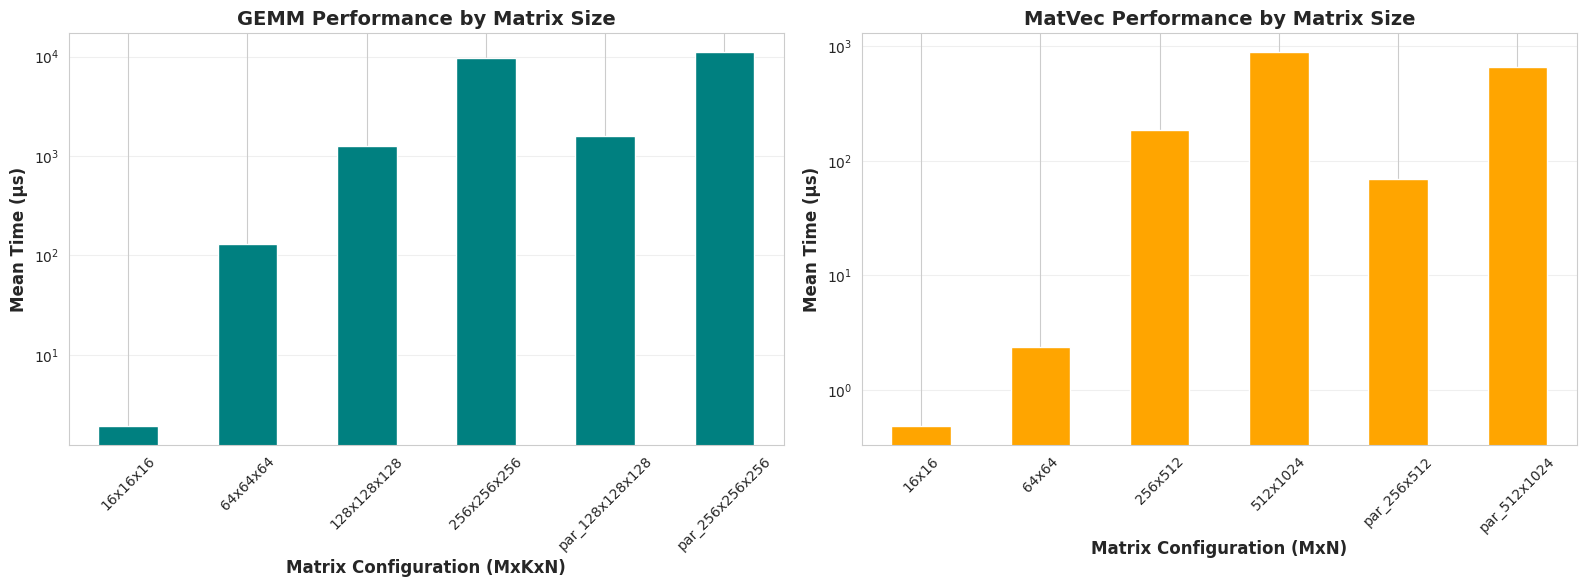

Linear algebra analysis visualization complete!


In [41]:
linalg_ops = df[df['category'] == 'linalg']

if len(linalg_ops) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. GEMM operations
    gemm_ops = linalg_ops[linalg_ops['operation'].str.contains('gemm')]
    if len(gemm_ops) > 0:
        gemm_ops['config'] = gemm_ops['operation'].str.replace('gemm_', '')
        gemm_ops.plot(x='config', y='mean_time_us', kind='bar', ax=axes[0], 
                      color='teal', legend=False)
        axes[0].set_title('GEMM Performance by Matrix Size', fontweight='bold', fontsize=14)
        axes[0].set_xlabel('Matrix Configuration (MxKxN)', fontweight='bold')
        axes[0].set_ylabel('Mean Time (µs)', fontweight='bold')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].set_yscale('log')
        axes[0].grid(axis='y', alpha=0.3)
    
    # 2. MatVec operations
    matvec_ops = linalg_ops[linalg_ops['operation'].str.contains('matvec')]
    if len(matvec_ops) > 0:
        matvec_ops['config'] = matvec_ops['operation'].str.replace('matvec_', '')
        matvec_ops.plot(x='config', y='mean_time_us', kind='bar', ax=axes[1],
                        color='orange', legend=False)
        axes[1].set_title('MatVec Performance by Matrix Size', fontweight='bold', fontsize=14)
        axes[1].set_xlabel('Matrix Configuration (MxN)', fontweight='bold')
        axes[1].set_ylabel('Mean Time (µs)', fontweight='bold')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].set_yscale('log')
        axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('linalg_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Linear algebra analysis visualization complete!")
else:
    print("No linear algebra operations found in benchmark results.")

## Summary Report

In [42]:
print("="*80)
print("HOLOGRAM-CORE BENCHMARK SUMMARY REPORT")
print("="*80)
print(f"\nBenchmark Date: {metadata['timestamp']}")
print(f"Platform: {metadata['platform']}")
print(f"Backend: {metadata['backend']}")
print(f"Total Benchmarks: {len(df)}")

print("\n" + "-"*80)
print("PERFORMANCE BY CATEGORY")
print("-"*80)
for category in df['category'].unique():
    cat_data = df[df['category'] == category]
    print(f"\n{category.upper()}:")
    print(f"  Operations: {len(cat_data)}")
    print(f"  Mean Time: {cat_data['mean_time_us'].mean():.2f} µs")
    print(f"  Median Time: {cat_data['mean_time_us'].median():.2f} µs")
    print(f"  Mean Throughput: {cat_data['throughput_mops'].mean():.2f} Mops/s")
    print(f"  Best Operation: {cat_data.loc[cat_data['mean_time_us'].idxmin(), 'operation']}")
    print(f"  Best Time: {cat_data['mean_time_us'].min():.2f} µs")

print("\n" + "-"*80)
print("TOP 5 FASTEST OPERATIONS")
print("-"*80)
fastest_5 = df.nsmallest(5, 'mean_time_us')
for idx, row in fastest_5.iterrows():
    print(f"{row['operation']:20s} (size={row['size']:6d}): {row['mean_time_us']:8.2f} µs")

print("\n" + "-"*80)
print("TOP 5 HIGHEST THROUGHPUT OPERATIONS")
print("-"*80)
top_throughput_5 = df.nlargest(5, 'throughput_mops')
for idx, row in top_throughput_5.iterrows():
    print(f"{row['operation']:20s} (size={row['size']:6d}): {row['throughput_mops']:8.2f} Mops/s")

# Addressing mode comparison
if len(both_modes) > 0 and 'PhiCoordinate' in df['addressing_mode'].values:
    print("\n" + "-"*80)
    print("ADDRESSING MODE COMPARISON")
    print("-"*80)
    phi_data = df[df['addressing_mode'] == 'PhiCoordinate']
    buffer_data = df[df['addressing_mode'] == 'BufferOffset']
    print(f"PhiCoordinate Mean Time: {phi_data['mean_time_us'].mean():.2f} µs")
    print(f"BufferOffset Mean Time: {buffer_data['mean_time_us'].mean():.2f} µs")
    if len(phi_data) > 0 and len(buffer_data) > 0:
        speedup = buffer_data['mean_time_us'].mean() / phi_data['mean_time_us'].mean()
        print(f"PhiCoordinate Speedup: {speedup:.2f}x")

print("\n" + "="*80)
print("Report generation complete! All visualizations saved.")
print("="*80)

HOLOGRAM-CORE BENCHMARK SUMMARY REPORT

Benchmark Date: 2025-11-03T17:11:51
Platform: linux
Backend: cpu
Total Benchmarks: 118

--------------------------------------------------------------------------------
PERFORMANCE BY CATEGORY
--------------------------------------------------------------------------------

MATH:
  Operations: 55
  Mean Time: 27265.71 µs
  Median Time: 4.80 µs
  Mean Throughput: 3393.87 Mops/s
  Best Operation: abs
  Best Time: 0.09 µs

ACTIVATION:
  Operations: 16
  Mean Time: 12.58 µs
  Median Time: 8.01 µs
  Mean Throughput: 361.23 Mops/s
  Best Operation: gelu
  Best Time: 0.78 µs

REDUCTION:
  Operations: 15
  Mean Time: 7666.47 µs
  Median Time: 1998.56 µs
  Mean Throughput: 2.72 Mops/s
  Best Operation: max_reduce
  Best Time: 42.65 µs

LOSS:
  Operations: 12
  Mean Time: 70064.36 µs
  Median Time: 2380.59 µs
  Mean Throughput: 1.22 Mops/s
  Best Operation: mse
  Best Time: 87.83 µs

LINALG:
  Operations: 12
  Mean Time: 2136.94 µs
  Median Time: 426.05 µs

## Export Summary Data

Export processed data for further analysis or sharing.

In [ ]:
# Export summary statistics to CSV
summary_stats = df.groupby(['category', 'operation', 'size']).agg({
    'mean_time_us': ['mean', 'std', 'min', 'max'],
    'throughput_mops': ['mean', 'std'],
    'cv': 'mean'
}).reset_index()

summary_stats.to_csv('benchmark_summary.csv', index=False)
print("Summary statistics exported to benchmark_summary.csv")

# Export full processed dataframe
df.to_csv('benchmark_full_data.csv', index=False)
print("Full benchmark data exported to benchmark_full_data.csv")